# Seguro Auto - Modelagem
___
Uma seguradora que fornece seguro saúde para seus clientes tem interesse na construção de um modelo para prever se seus clientes do ano passado também estarão interessados no seguro auto fornecido pela empresa.

Uma apólice de seguro é um acordo pelo qual uma empresa se compromete a fornecer uma garantia de compensação por perdas, danos, doenças ou morte especificados em troca do pagamento de um prêmio especificado - uma quantia em dinheiro, que o cliente precisa pagar regularmente a uma seguradora por essa garantia.

Assim como o seguro de saúde, existe o seguro auto em que todos os anos o cliente paga um prêmio de determinado valor à seguradora para que, em caso de acidente com o veículo, a seguradora forneça uma indenização para o consumidor.

### Problema de Negócio
___
O problema de negócio consiste basicamente em prever quais clientes do ano anterior estarão interessados no seguro auto oferecido pela empresa, para que assim o time de vendas possa priorizar as pessoas com maior interesse no produto oferecido, otimizando assim a campanha voltada para os principais clientes.
Nesse contexto, o notebook visa implementar um algoritmo de aprendizado de máquina com o objetivo de prever se um cliente terá ou não interesse no seguro auto da empresa baseando-se em determinados atributos presentes.

### Os dados
___
O [dataset](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction) apresenta dados de treinamento para um modelo de previsão de seguros auto, com 381109 instâncias e 11 variáveis, dentre as quais foram escolhidas durante o pré-processamento:
- `id` $\to$ id único do cliente
- `Age` $\to$ idade do cliente
- `Previously_Insured`$\to$ cliente possui (1) ou não (0) seguro
- `Vehicle_Age` $\to$ idade do veículo
- `Vehicle_Damage`$\to$ veículo danificado (1) ou não (0) no passado
- `Policy_Sales_Channel`$\to$ canal de atendimento ao cliente
- `Response`$\to$ cliente interessado (1) ou não (0) no seguro

# 1. Importar df

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings as wn

plt.style.use('ggplot')

wn.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_pp.csv', index_col='id')

In [3]:
df.head()

,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response
id,,,,,,
1,44,0,2,1,26.0,1
2,76,0,1,0,26.0,0
3,47,0,2,1,26.0,1
4,21,1,0,0,152.0,0
5,29,1,0,0,152.0,0


In [4]:
df.shape

(370789, 6)

In [5]:
df.query('Response==0').shape[0]/df.shape[0]

0.8782191488960028

In [6]:
df.query('Response==1').shape[0]/df.shape[0]

0.12178085110399715

# 2. Pré-processamento

- Split dataset em treino e teste

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(['Response'], axis=1)
y = df['Response']
indices = np.arange(X.shape[0])

In [9]:
x_train, x_test, y_train, y_test, idx1, idx2 = train_test_split(X, y, indices, test_size=0.3)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((259552, 5), (111237, 5), (259552,), (111237,))

In [11]:
idx1_df = df.iloc[idx1,:].index
idx2_df = df.iloc[idx2,:].index

# 3. Aprendizado de Máquina

- Importar métricas

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

### Métricas
___
As métricas de avaliação dos modelos foram:

- Precision: de todos os clientes que o modelo previu que permaneceriam, quantos deles realmente permaneceram?
$$ Precision = \frac{TP}{(TP+FP)} $$


- Recall: % de clientes previstos que permaneceriam que o modelo previu corretamente?
$$ Recall = \frac{TP}{(TP+FN)}$$


- F1: medida relativa de precision e recall (média harmônica):
$$ F_1 = \frac{TP}{(TP + \frac{1}{2}(FP+FN))}$$


- ROC-AUC: relação entre taxas de TP e FP, sendo que a AUC (área sob a curva) sumariza a ROC em um único número (quão mais próxima de 1, melhor o classificador em relação á taxa de falsos positivos).

onde TP$\to$true positive, FP$\to$false positive (erro tipo I), e FN$\to$false negative (erro tipo II).



### Avaliação em função do problema de negócio
___

Nesse contexto, temos que:
- TP $\to$ previsão de que o cliente manteria o seguro, o que ocorre $\to$ ganho monetário, pois cliente permanece
- TN $\to$ previsão de que o cliente cancelaria o seguro, o que ocorre $\to$ perda monetária, pois cliente cancela seguro
- FP $\to$ previsão de que o cliente manteria o seguro, o que não ocorre $\to$ perda monetária, pois o cliente cancela o seguro
- FN $\to$ previsão de que o cliente cancelaria o seguro, o que não ocorre $\to$ ganho monetário, pois o cliente permanece

Baseando-se nas métricas, procuramos um modelo que apresente um baixo valor de FP i.e. clientes que manteriam o seguro, mas que na realidade o cancelaram, pois gera perda monetária, bem como uma alta taxa de TP, os seja, retenção clientes $\to$ e.g. boa performance de ROC-AUC i.e. baixa taxa de falsos positivos, e alta taxa de verdadeiros positivos.

Considerando os valores de prêmio anuais da base de dados pré-processada, a média é aproximadamente \\$30k, valor muito acima da média de mercado. No projeto, foram considerados um prêmio médio nos EUA de \\$1427 (*customer lifetime value*) [[1]](https://www.nerdwallet.com/blog/insurance/car-insurance-basics/how-much-is-car-insurance/#:~:text=The%20national%20average%20cost%20of,and%20a%20clean%20driving%20record.), e um custo de campanha de marketing de 3.3% em relação ao prêmio médio, ou seja, \\$42.8 [[2]](https://www.iamagazine.com/viewpoints/student-of-the-industry-insurance-ads-who-spends-what-and-why). 

Aplicando, portanto, uma campanha de marketing aplicada aos clientes com maior probabilidade de permanecer, é possível elaborar uma matriz de custo-benefício em função da própria campanha, onde caso a campanha de marketing consiga manter o cliente, a receita seria do número $n$ de clientes multiplicado pelo LTV menos o custo com marketing $\to n*(LTV-marketing)$, e caso a campanha seja aplicada a clientes que de fato sairiam (FP), a receita seria $\to k*marketing$:

- TP - benefício $\to$ \\$1384.2 $\to$ previu que o cliente continuaria, e aplicou campanha de marketing - retenção
- TN - benefício $\to$ \\$0 $\to$ previu que o cliente sairia, e ele saiu, então não houve campanha de marketing
- FP - custo $\to$ \\$-42.8 $\to$ previu que o cliente ficaria, mas o cliente saiu, e aplicou campanha de marketing - sem retenção
- FN - custo $\to$ \\$0 $\to$ previu que o cliente sairia, mas ele permaneceu

É importante denotar que a matriz de custo-benefício acima, como comentado, foi elaborada em função da campanha de marketing. Claramente, existe perda de receita devido ao TN i.e. para clientes que cancelam o seguro, onde a perda de receita seria o número $n$ de clientes multiplicado pelo LTV $\to n*LTV$. 

É possível calcular também o retorno sobre o investimento (ROI) de marketing devido à retenção de clientes:

$$ROI = \frac{retorno}{investimento} \to \frac{retenção}{marketing}$$

Outra análise de grande importância é a de valor esperado, a qual calcula o valor esperado de lucro para a campanha de marketing em função do resultado dos modelos de aprendizado de máquina, ou seja:

$$EV = p(o_1)v(o_1) + p(o_2)v(o_2) + ...$$

onde $p(o_i)$ é a probabilidade do evento, e $v(o_i)$ é seu valor. Considerando a matriz de custo-benefício apresentada acima, é juntamente com a equação de valor esperado, pode-se calcular o valor esperado de lucro em função das probabilidades de TP,TN,FP,FN, considerando as probabilidades de ocorrência de cada classe i.e. p(0) = 0.878, e p(1) = 0.122 [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/):

$$EV_{profit} = p(1)*[p(Y|1)b(Y,1) + p(N|1)c(N,1)] + $$
$$p(0)*[p(N|0)b(N,0) + p(Y|0)c(Y,0)] $$

onde:
- p $\to$ probabilidade
- b e c $\to$ benefício e custo
- 0 e 1 $\to$ cancelar ou manter o seguro
- N e Y $\to$ previsão de cancelar ou manter o seguro

Pode-se, portanto, reescrever a equação de *EV* como aplicando-se os valores de custo e benefício, :

$$EV_{profit} = 0.122*[1384.2p(Y|1) - 0p(N|1)] + 0.878*[0p(N|0) - 42.8p(Y|0)] \to$$

$$EV_{profit} = \$168.9p(Y|1) - \$37.6p(Y|0) $$

Nota-se que, enquanto a retenção possui uma magnitude de \\$168.9xTP, a campanha de marketing aplicada a clientes que não iriam cancelar o seguro possui uma magnitude de \\$-37.6xFP. Busca-se, então, altos valores de TP e baixos valores de FP, visando obter um maior lucro esperado, ou seja, maximização da AUC como comentado acima, utilizando, portanto, *ROC-AUC* como métrica de otimização.


In [94]:
# matriz de custo-benefício
# tn, fp, fn, tp
cb = np.array([[0,-42.8],[0,3184.2]])
              
pd.DataFrame(np.array([[0,-42.8],[0,1384.2]]), index=['True_0','True_1'], 
             columns=['Pred_0','Pred_1'])

,Pred_0,Pred_1
True_0,0.0,-42.8
True_1,0.0,1384.2


In [14]:
# probabilidade de continuar com seguro ou cancelá-lo
p_0 = df.query('Response==0').shape[0]/df.shape[0]
p_1 = df.query('Response==1').shape[0]/df.shape[0]
p_0, p_1

(0.8782191488960028, 0.12178085110399715)

## 3.1. Baseline: Decision Stump
___

**Decision Stump** é uma estratégia na qual se escolhe o único e mais informativo atributo presente entre as os preditores e baser todas as decisões neste atributo. No presente caso, utiliza-se uma árvore de decisão com somente um nó interno, ou seja, o nó raiz (*root node*), onde a árvore de decisão seleciona um único atributo com maior ganho de informação para a decisão [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/).

Nota-se pela matriz de confusão abaixo que o modelo classificou todas as instâncias como classe majoritária, ou seja, entre 111237 instâncias, sendo que 97761 da Classe 0 (`Response`=0) e 13476 da Class 1 (`Response`=1), o modelo classificou corretamente todas as instâncias da Classe 0, e classificou incorretamente todas as instâncias da Classe 1, atribuindo-as à Classe 0 $\to$ classificador majoritário com *ROC-AUC score* de 0.77 e, claramente, acurácia de 0.878.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
# baseline
dt = DecisionTreeClassifier(max_depth=1, random_state=42)

dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

In [17]:
# avaliar modelo - acurácia
kfold = KFold(n_splits=5, random_state=42)
dt_results = cross_val_score(dt, x_train, y_train, cv=kfold)
dt_results.mean()

0.8779358322709918

In [18]:
# predição
dt_predict = dt.predict(x_test)
dt_proba = dt.predict_proba(x_test)[:,1]

In [19]:
# métricas de comparação
print('Precision:',precision_score(y_test, dt_predict))
print('Recall:',recall_score(y_test, dt_predict))
print('F1:',f1_score(y_test, dt_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, dt_proba))

Precision: 0.0
Recall: 0.0
F1: 0.8222242637950347
ROC-AUC: 0.7711730907409425


In [20]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, dt_predict))

,0,1
0,97764,0
1,13473,0


### 2.2 - Regressão Logística
___
A regressão logística é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas, sendo um modelo de fácil explicação e rápido. Mais em [[4]](https://github.com/renan2scarvalho/Applied-Data-Science-with-Python/blob/master/3%20Applied%20Machine%20Learning%20in%20Python/cesarian.ipynb).

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
# modelo
lr = LogisticRegression(class_weight='balanced',random_state=42,n_jobs=-1)

lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [23]:
# avaliar modelo
kfold = KFold(n_splits=5, random_state=42)
lr_results = cross_val_score(lr, x_train, y_train, cv=kfold)
lr_results.mean()

0.6388238181659412

In [24]:
# predição
lr_predict = lr.predict(x_test)
lr_proba = lr.predict_proba(x_test)[:,1]

In [25]:
# métricas
print('Precision:',precision_score(y_test, lr_predict))
print('Recall:',recall_score(y_test, lr_predict))
print('F1:',f1_score(y_test, lr_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, lr_proba))

Precision: 0.24846915633504688
Recall: 0.9758034587693907
F1: 0.7011159672732866
ROC-AUC: 0.8301416568253729


In [26]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, lr_predict))

,0,1
0,57999,39765
1,326,13147


### 2.3. Random Forest
___
Random Forests é um conjunto de Árvores de Decisão com Bootstrap Aggregation (bagging), onde as árvores são executadas em paralelo, o que significa que não há interação entre elas. Mais em [[4]](https://github.com/renan2scarvalho/Applied-Data-Science-with-Python/blob/master/3%20Applied%20Machine%20Learning%20in%20Python/cesarian.ipynb).

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
# classificador
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [29]:
# avaliar modelo
kfold = KFold(n_splits=5, random_state=42)
rfc_results = cross_val_score(rfc, x_train, y_train, cv=kfold)
rfc_results.mean()

0.7167273006393019

In [30]:
# predição
rfc_predict = rfc.predict(x_test)
rfc_proba = rfc.predict_proba(x_test)[:,1]

In [31]:
# métricas
print('Precision:',precision_score(y_test, rfc_predict))
print('Recall:',recall_score(y_test, rfc_predict))
print('F1:',f1_score(y_test, rfc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, rfc_proba))

Precision: 0.2813306499348881
Recall: 0.8819119720923329
F1: 0.7621983137009286
ROC-AUC: 0.8412898159546032


In [32]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, rfc_predict))

,0,1
0,67411,30353
1,1591,11882


### 2.4. Extreme Gradient Boosting (XGBoost)
___
Similar ao algoritmo Gradient Boosting, mas com alguns diferenciais, como melhor penalização das árvores de decisão, encolhimento proporcional dos nós, dentre outros, sendo computacionalmente eficiente (rápido na execução) e altamente efetivo. Mais em [5]](https://en.wikipedia.org/wiki/XGBoost), [[6]](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/).

Um valor de *scale_pos_weight* foi utilizado devido às classes desbalanceadas [[7]](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

In [33]:
from xgboost.sklearn import XGBClassifier

In [34]:
# desbalanço
spw = round(np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1])
spw

7

In [35]:
# classificador
xgb = XGBClassifier(scale_pos_weight=spw, random_state=42, n_jobs=-1)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# avaliar modelo
kfold = KFold(n_splits=5, random_state=42)
xgb_results = cross_val_score(xgb, x_train, y_train, cv=kfold)
xgb_results.mean()

0.7127935954548053

In [37]:
# predição
xgb_predict = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)[:,1]

In [38]:
# métricas
print('Precision:',precision_score(y_test, xgb_predict))
print('Recall:',recall_score(y_test, xgb_predict))
print('F1:',f1_score(y_test, xgb_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, xgb_proba))

Precision: 0.284746554543331
Recall: 0.9047725079789208
F1: 0.7626304412851559
ROC-AUC: 0.8540565314764567


In [39]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, xgb_predict))

,0,1
0,67144,30620
1,1283,12190


# 3. Avaliação
___

## 3.1. Métricas
___


De acordo com as métricas de avaliação apontadas no começo, buscamos uma baixa tada de FP (previsão de que o cliente vai permanecer com a seguradora e o mesmo cancela o seguro). Nesse contexto, dentre os modelos utilizados, os que apresentaram melhor desempenho foram o modelo de árvore: Random Forest e XGBoost, ambos com taxa de FP de 0.31 e 0.32, respectivamente.

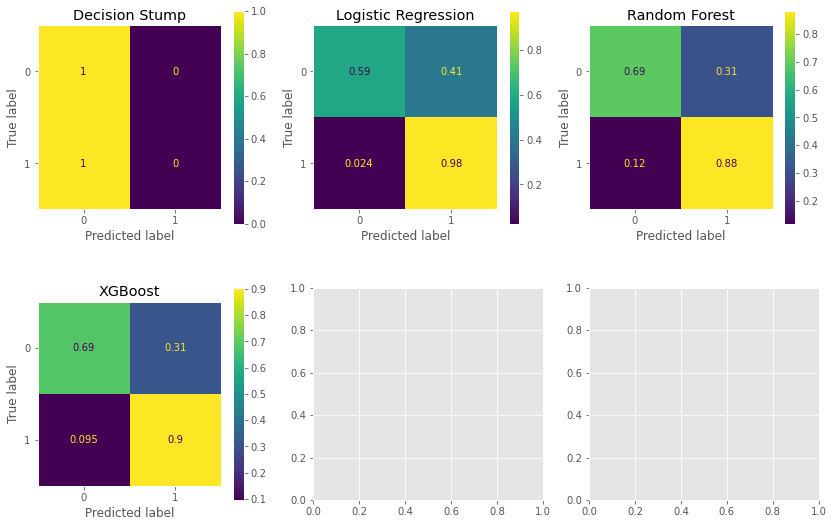

In [40]:
# confusion matrix normalized
fig, [[ax0,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=(14,9))
plot_confusion_matrix(dt, x_test, y_test, normalize='true', ax=ax0)
ax0.set(title='Decision Stump')
plot_confusion_matrix(lr, x_test, y_test, normalize='true', ax=ax1)
ax1.set(title='Logistic Regression')
plot_confusion_matrix(rfc, x_test, y_test, normalize='true', ax=ax2)
ax2.set(title='Random Forest')
plot_confusion_matrix(xgb, x_test, y_test, normalize='true', ax=ax3)
ax3.set(title='XGBoost')

for ax in [ax0,ax1,ax2,ax3]:
    ax.grid(False)
    
plt.subplots_adjust(hspace=0.3)

A curva ROC é uma forma gráfica de revisar o desempenho dos modelos de classificação, sendo um bom indicador de desempenho, especialmente porque estamos interessados na taxa de TP dos modelos. A área sob a curva (AUC) mede a capacidade do modelo de classificar corretamente aqueles que tiveram evasão, e os que não tiveram. Quanto maior a AUC, melhor o classificador em relação à taxa de TP.

Analisando a figura abaixo, nota-se que o modelo XGBoost apresentou a maior AUC entre os modelos, ligeiramente superior ao modelo Random Forest, e por fim o modelo de Regressão Logística.

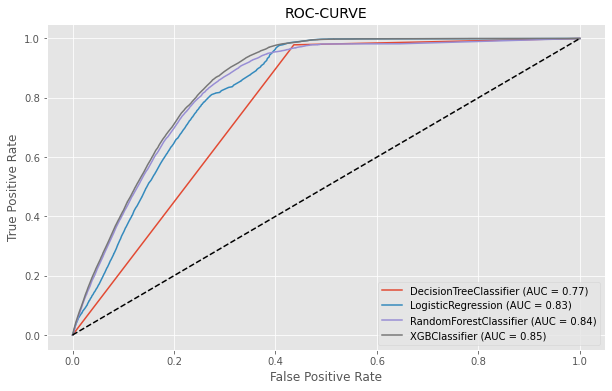

In [41]:
# ROC-AUC
fig, ax=plt.subplots(figsize=(10,6))
plot_roc_curve(dt, x_test, y_test, ax=ax)
plot_roc_curve(lr, x_test, y_test, ax=ax)
plot_roc_curve(rfc, x_test, y_test, ax=ax)
plot_roc_curve(xgb, x_test, y_test, ax=ax)
ax.plot([0,1], [0,1], linestyle='--', color='k')
plt.title('ROC-CURVE', size=14);

## 3.2. Ajuse te Hiperparâmetros
___

### Regressão Logística
___
O modelo de regressão logística demanda normalização quando regularização é utilizada [[8]](https://www.dataschool.io/comparing-supervised-learning-algorithms/).

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()

In [44]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [208]:
# parâmetros para random search
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['newton-cg','liblinear','lbfgs']
penalty = ['l1','l2']
params = dict(C=C, solver=solver, penalty=penalty)

# classificador
clf = LogisticRegression(class_weight='balanced', random_state=42)

# search
kfold = KFold(n_splits=3, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='roc_auc', 
                            cv = kfold,
                            n_jobs=-1, 
                            verbose=1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


{'solver': 'liblinear', 'penalty': 'l2', 'C': 100}

In [209]:
# modelo
lr = LogisticRegression(solver='liblinear',C=100,penalty='l2',
                        class_weight='balanced',random_state=42,n_jobs=-1)

lr.fit(x_train_sc, y_train)

LogisticRegression(C=100, class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='liblinear')

In [210]:
# avaliar modelo
kfold = KFold(n_splits=5, random_state=42)
lr_results = cross_val_score(lr, x_train_sc, y_train, cv=kfold, scoring='roc_auc')
lr_results.mean()

0.8316285353398524

In [211]:
# predição
lr_proba = lr.predict_proba(x_test_sc)[:,1]

# mudar cutoff 
lr_predict = np.zeros(lr_proba.shape)
lr_predict = np.array([1 if lr_proba[i] > 0.65 else 0 for i in range(lr_predict.shape[0])])

In [212]:
# métricas
print('Precision:',precision_score(y_test, lr_predict))
print('Recall:',recall_score(y_test, lr_predict))
print('F1:',f1_score(y_test, lr_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, lr_proba))

Precision: 0.2963193834471425
Recall: 0.7762191048764195
F1: 0.7899213378938093
ROC-AUC: 0.8301416568253729


In [213]:
# matriz de confusão
lr_cm = confusion_matrix(y_test, lr_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, lr_predict))

,0,1
0,72929,24835
1,3015,10458


### Random Forest
___

In [214]:
# parâmetros para random search
max_depth = [3, 5, 8, 10]
min_samples_split = [10, 50, 100, 300]
max_leaf_nodes = [5, 10, 30, 50]
min_samples_leaf = [2, 3, 5, 10]
n_estimators = [50, 100, 300, 500]
max_samples = [0.1, 0.2, 0.5, 1]
params = dict(max_depth=max_depth,
             min_samples_split=min_samples_split,
             max_leaf_nodes=max_leaf_nodes,
             min_samples_leaf=min_samples_leaf,
             n_estimators=n_estimators,
             max_samples=max_samples)

# classificador
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# search
kfold = KFold(n_splits=3, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='roc_auc', 
                            cv = kfold,
                            n_jobs=-1, 
                            verbose=1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


{'n_estimators': 500,
 'min_samples_split': 100,
 'min_samples_leaf': 3,
 'max_samples': 0.1,
 'max_leaf_nodes': 50,
 'max_depth': 10}

In [215]:
# modelo
rfc = RandomForestClassifier(n_estimators=500,
                             min_samples_split=100,
                             min_samples_leaf=3,
                             max_samples=0.1,
                             max_leaf_nodes=50,
                             max_depth=10,
                             class_weight='balanced', 
                             random_state=42)

rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=50,
                       max_samples=0.1, min_samples_leaf=3,
                       min_samples_split=100, n_estimators=500,
                       random_state=42)

In [221]:
# avaliar modelo 
kfold = KFold(n_splits=5, random_state=42)
rfc_results = cross_val_score(rfc, x_train, y_train, cv=kfold, scoring='roc_auc')
rfc_results.mean()

0.8529551454959314

In [218]:
# predição
rfc_predict = rfc.predict(x_test)
rfc_proba = rfc.predict_proba(x_test)[:,1]

In [219]:
# métricas
print('Precision:',precision_score(y_test, rfc_predict))
print('Recall:',recall_score(y_test, rfc_predict))
print('F1:',f1_score(y_test, rfc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, rfc_proba))

Precision: 0.27814718303531316
Recall: 0.9190232316484821
F1: 0.7530753809131977
ROC-AUC: 0.8533253367155553


In [220]:
# matriz de confusão
rfc_cm = confusion_matrix(y_test, rfc_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, rfc_predict))

,0,1
0,65630,32134
1,1091,12382


### XGBoost
___

In [222]:
# parâmetros para random search
n_estimators = [100, 300, 500, 800]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
subsample = [0.5, 0.8, 1]
max_depth = [3, 5, 8, 10]
gamma = [0, 0.1, 0.5]
min_child_weight = [1, 3, 5]
colsample_bytree = [0.5, 0.8, 1]
scale_pos_weight = [3, 4, 5, 8]
params = dict(n_estimators=n_estimators, 
              learning_rate=learning_rate, 
              subsample=subsample,
              max_depth=max_depth,
              gamma=gamma,
              min_child_weight=min_child_weight,
              colsample_bytree=colsample_bytree,
              scale_pos_weight=scale_pos_weight)

# classificador
clf = XGBClassifier(random_state=42)

# search
kfold = KFold(n_splits=3, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='roc_auc', 
                            cv=kfold,
                            verbose=1, 
                            n_jobs=-1).fit(x_train, y_train)

# avaliar parâmetros
search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.0min finished


{'subsample': 0.5,
 'scale_pos_weight': 4,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.8}

In [223]:
# modelo
xgb = XGBClassifier(subsample=0.5,
                     scale_pos_weight=4,
                     n_estimators=300,
                     min_child_weight=1,
                     max_depth=3,
                     learning_rate=0.2,
                     gamma=0.1,
                     colsample_bytree=0.8)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [225]:
# avaliar modelo
kfold = KFold(n_splits=5, random_state=42)
xgb_results = cross_val_score(xgb, x_train, y_train, cv=kfold, scoring='precision')
xgb_results.mean()

0.31317570438932624

In [226]:
# predição
xgb_predict = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)[:,1]

In [227]:
# métricas
print('Precision:',precision_score(y_test, xgb_predict))
print('Recall:',recall_score(y_test, xgb_predict))
print('F1:',f1_score(y_test, xgb_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, xgb_proba))

Precision: 0.312836213803365
Recall: 0.8114748014547614
F1: 0.7994861948703037
ROC-AUC: 0.8554613811602463


In [228]:
# matriz de confusão
xgb_cm = confusion_matrix(y_test, xgb_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, xgb_predict))

,0,1
0,73749,24015
1,2540,10933


### Comparação
___

Os valores *a priori* e *a posteriori* do ajuste dos hiperparâmetros em função do probléma de negócio são:

- Regressão Logística: 
    - TP: 0.98 $\to$ 0.98
    - FP: 0.41 $\to$ 0.41
- Random Forest:
    - TP: 0.88 $\to$ 0.92
    - FP:  0.31 $\to$ 0.33
- XGBoost: 
    - TP: 0.90 $\to$ 0.81
    - FP: 0.31 $\to$ 0.25

De maneira geral, observa-se que o modelo de regressão manteve os mesmos valores (pode ser visto também na curva ROC-AUC abaixo), enquanto o modelo Random Forest teve um aumento de TP e também FP, superior para o primeiro parâmetro, o que refletiu em um aumento da AUC de 0.84 $\to$ 0.85, e no último modelo, XGBoost, ocorreu uma redução de ambos os parâmetros, com aumento na AUC de 0.85 $\to$ 0.86.

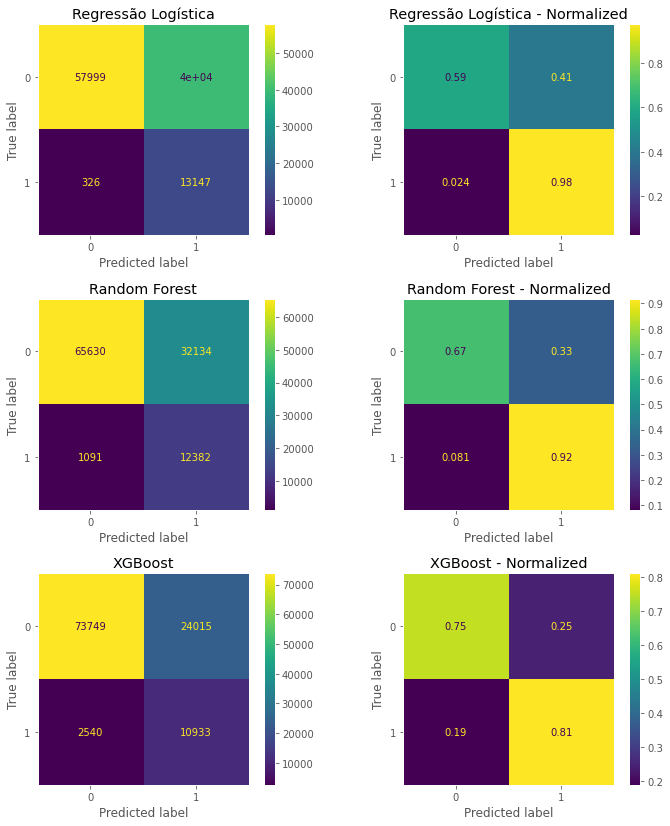

In [229]:
# matriz de confusão
# RL
fig, [[ax0,ax1],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(12,14))
plt.subplots_adjust(hspace=.3)
plot_confusion_matrix(lr, x_test_sc, y_test, ax=ax0)
ax0.grid(False)
ax0.set(title='Regressão Logística')
plot_confusion_matrix(lr, x_test_sc, y_test, normalize='true',ax=ax1)
ax1.grid(False)
ax1.set(title='Regressão Logística - Normalized')
# RFC
plot_confusion_matrix(rfc, x_test, y_test, ax=ax3)
ax3.grid(False)
ax3.set(title='Random Forest')
plot_confusion_matrix(rfc, x_test, y_test, normalize='true',ax=ax4)
ax4.grid(False)
ax4.set(title='Random Forest - Normalized');
# XGB
plot_confusion_matrix(xgb, x_test, y_test, ax=ax5)
ax5.grid(False)
ax5.set(title='XGBoost')
plot_confusion_matrix(xgb, x_test, y_test, normalize='true',ax=ax6)
ax6.grid(False)
ax6.set(title='XGBoost - Normalized');

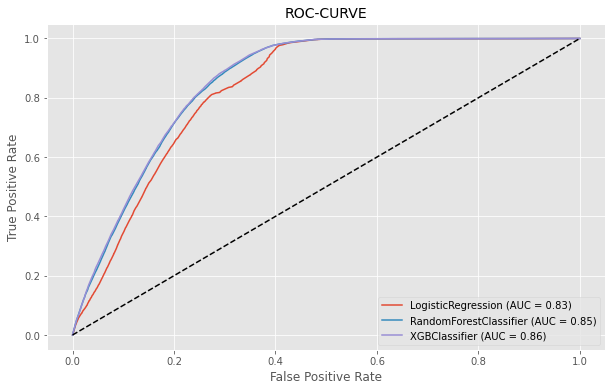

In [230]:
# ROC-AUC
fig, ax=plt.subplots(figsize=(10,6))
plot_roc_curve(lr, x_test_sc, y_test, ax=ax)
plot_roc_curve(rfc, x_test, y_test, ax=ax)
plot_roc_curve(xgb, x_test, y_test, ax=ax)
ax.plot([0,1], [0,1], linestyle='--', color='k')
plt.title('ROC-CURVE', size=14);

## 3.2. Lucro Esperado
___
Entretanto, quando aplicada a equação de valor esperado de lucro mencionada acima, foi possível calcular o valor esperado em função da performance dos classificadores e da matriz de custo-benefício, ou seja, considerando tanto os aspectos técnicos do classificador quanto o plano de retenção de clientes. 

Nota-se que o classficador com maior valor esperado é o modelo Random Forest, seguido pelo modelo XGBoost, e por fim o modelo de Regressão Logística, sendo o lucro esperado \\$344.02, \\$305.44, \\$291.45, respectivamente, todos apresentando lucro esperado positivo. Isso porque, como indicado, os modelos utilizaram como métrica de otimização a métrica *ROC-AUC*, visando reduzir o número de FP enquanto procurar um alto número de TP, como visto acima, aumentando o valor esperado de lucro.

In [231]:
print('Regressão Logística - Lucro Esperado: ${}'.format(
    round(
        p_1*((lr_cm[1][1]*cb[1][1]) + (lr_cm[1][0]*cb[1][0])) + 
        p_0*((lr_cm[0][0]*cb[0][0]) + (lr_cm[0][1]*cb[0][1])),
        2)
    )
)

Regressão Logística - Lucro Esperado: $291.45


In [232]:
print('Random Forest - Lucro Esperado: ${}'.format(
    round(
        p_1*((rfc_cm[1][1]*cb[1][1]) + (rfc_cm[1][0]*cb[1][0])) + 
        p_0*((rfc_cm[0][0]*cb[0][0]) + (rfc_cm[0][1]*cb[0][1])),
        2)
    )
)

Random Forest - Lucro Esperado: $344.02


In [233]:
print('Gradient Boosting - Lucro Esperado: ${}'.format(
    round(
        p_1*((xgb_cm[1][1]*cb[1][1]) + (xgb_cm[1][0]*cb[1][0])) + 
        p_0*((xgb_cm[0][0]*cb[0][0]) + (xgb_cm[0][1]*cb[0][1])),
        2)
    )
)

Gradient Boosting - Lucro Esperado: $305.44


### 3.2.1. Curvas de Lucro Esperado
___
Entretanto, uma estragégia diferente para a tomada de decisão pode ser o rankeamento das instâncias de acordo com seu score de churn, ou seja, sua probabilidade, onde, através dos resultados e visualização da curva das instâncias rankeadas por score, pode-se escolher determinado número $n$ de clientes para aplicar o plano de retenção, de acordo com o lucro máximo apresentado por cada classificador, como é também possível adaptar o plano de retenção com restrições orçamentárias para outro determinado número $n$ de clientes.

Mais especificamente, a classificação por rankeamento produz uma lista de instâncias e seus scores de probabilidade de forma decrescente, calculando-se o valor esperado resultando para cada instância da lista. Como é possível notar abaixo, a curva de lucro pode ser negativa, especialmente quando a margem de lucro é pequena e o número de clientes que o programa de retenção consegue atingir é também pequeno [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/). Diferentemente do valor esperado calculado anteriormente, o qual considera os valores totais do classificador, no caso da curva de valor esperado os valores de TP, TN, FP, FN mudam a cada e instância e, portanto, seu valor esperado.

In [280]:
df_cost = pd.DataFrame(y_test.values, index=idx2_df, columns=['y_true'])

In [375]:
def calculate_metrics(df, cb_matrix):
    
    """Calcula tp, tn, fp, fn, valor esperado e porcentagem de instâncias
    
    @param df: dataframe para adcionar cálculos
    @param cb_matrix: matriz de custo-benefício
    
    @return tp,tn,fp,fn,EV,perc_instances
    """
    
    y_true = np.array(df['y_true'])
    y_pred = np.array(df['predict'])
    
    tp = np.array([0]*df.shape[0])
    tn = np.array([0]*df.shape[0])
    fp = np.array([0]*df.shape[0])
    fn = np.array([0]*df.shape[0])
    EV = np.array([0]*df.shape[0])
    
    tp_aux,tn_aux,fp_aux,fn_aux = 0,0,0,0

    for i in range(df.shape[0]):

        # Calcular tp, tn, fp, fn
        if y_true[i]==1 and y_pred[i]==1: # tp
            tp_aux += 1
      
        elif y_true[i]==0 and y_pred[i]==0: # tn
            tn_aux+=1

        elif y_true[i]==0 and y_pred[i]==1: # fp
            fp_aux+=1

        elif y_true[i]==1 and y_pred[i]==0: # fn
            fn_aux+=1

        tp[i] = tp_aux
        tn[i] = tn_aux
        fp[i] = fp_aux
        fn[i] = fn_aux
    
    
    df['tp'] = tp
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['Instances'] = np.linspace(0,1,num=df.shape[0])
    df['EV'] = (df['tn']*cb_matrix[0][0] + df['fp']*cb_matrix[0][1] + \
                df['fn']*cb_matrix[1][0] + df['tp']*cb_matrix[1][1]) / \
                df.shape[0]
    df['EV'] = df['EV'].round(1)
    
    return 'End of calculation'

### Regressão Logística
___

In [376]:
lr_cost = df_cost.copy()
lr_cost['predict'] = lr_predict
lr_cost['proba'] = lr_proba
lr_cost = lr_cost.sort_values(by='proba', ascending=False)

In [377]:
calculate_metrics(lr_cost,cb)

'End of calculation'

In [378]:
lr_cost.head()

,y_true,predict,proba,tp,tn,fp,fn,Instances,EV
id,,,,,,,,,
261089,0,1,0.900234,0,0,1,0,0.000000,-0.0
203714,0,1,0.898329,0,0,2,0,0.000009,-0.0
334419,0,1,0.898329,0,0,3,0,0.000018,-0.0
187321,1,1,0.898188,1,0,3,0,0.000027,0.0
331764,0,1,0.896714,1,0,4,0,0.000036,0.0


### Random Forest
___

In [379]:
rfc_cost = df_cost.copy()
rfc_cost['predict'] = rfc_predict
rfc_cost['proba'] = rfc_proba
rfc_cost = rfc_cost.sort_values(by='proba', ascending=False)

In [380]:
calculate_metrics(rfc_cost,cb)

'End of calculation'

In [381]:
rfc_cost.head()

,y_true,predict,proba,tp,tn,fp,fn,Instances,EV
id,,,,,,,,,
378484,0,1,0.84229,0,0,1,0,0.000000,-0.0
269002,1,1,0.84229,1,0,1,0,0.000009,0.0
121485,0,1,0.84229,1,0,2,0,0.000018,0.0
225715,0,1,0.84229,1,0,3,0,0.000027,0.0
112322,0,1,0.84229,1,0,4,0,0.000036,0.0


### XGBoost
___

In [382]:
xgb_cost = df_cost.copy()
xgb_cost['predict'] = xgb_predict
xgb_cost['proba'] = xgb_proba
xgb_cost = xgb_cost.sort_values(by='proba', ascending=False)

In [383]:
calculate_metrics(xgb_cost,cb)

'End of calculation'

In [384]:
xgb_cost.head()

,y_true,predict,proba,tp,tn,fp,fn,Instances,EV
id,,,,,,,,,
149327,0,1,0.907928,0,0,1,0,0.000000,-0.0
6294,0,1,0.905270,0,0,2,0,0.000009,-0.0
96650,0,1,0.897081,0,0,3,0,0.000018,-0.0
333436,0,1,0.897081,0,0,4,0,0.000027,-0.0
165609,1,1,0.897081,1,0,4,0,0.000036,0.0


Nota-se pelas curvas de lucro que:

- Regressão Logística: lucro esperado de \\$289.8 com 31.73% das instâncias, correspondendo a 35291 clientes
- Random Forest: lucro esperado de \\$342.1 com 40.02% do número de instâncias de teste, o que representa 44515 clientes
- XGBoost: lucro esperado máximo de \\$303.7 com 31.42% do total de instâncias, o que representa 34947 clientes. 

Portanto, avaliando todas as instâncias de test, o lucro esperado máximo de \\$342.1 seria encontrado com o classificador Random Forest.

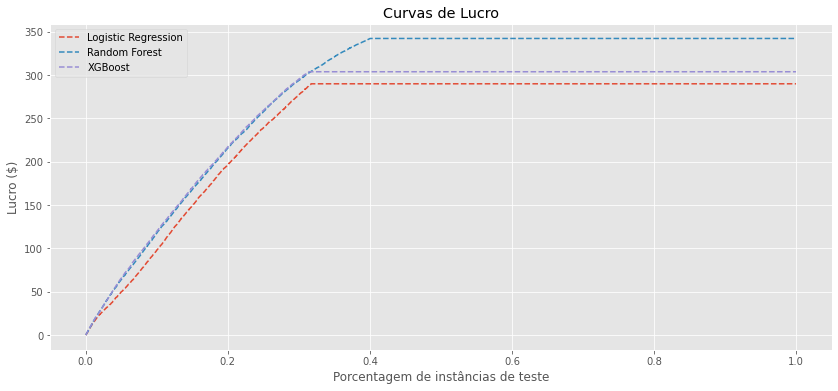

In [393]:
fig, ax=plt.subplots(figsize=(14,6))
ax.plot(lr_cost['Instances'],lr_cost['EV'], linestyle='--', label='Logistic Regression')
ax.plot(rfc_cost['Instances'],rfc_cost['EV'], linestyle='--', label='Random Forest')
ax.plot(xgb_cost['Instances'],xgb_cost['EV'], linestyle='--', label='XGBoost')
plt.legend()
ax.set(title='Curvas de Lucro', xlabel='Porcentagem de instâncias de teste',
      ylabel='Lucro ($)');

In [395]:
print('Regressão Logística: Lucro máximo esperado de ${} com {}% das instâncias ({} clientes)'.format(
    lr_cost.query('tp == 10458').head(1)['EV'].values[0],
    round(lr_cost.query('tp == 10458').head(1)['Instances'].values[0]*100,2),
    round((lr_cost.query('tp == 10458').head(1)['Instances'].values*lr_cost.shape[0])[0]))
)

Regressão Logística: Lucro máximo esperado de $289.8 com 31.73% das instâncias (35291 clientes)


In [387]:
print('Random Forest: Lucro máximo esperado de ${} com {}% das instâncias ({} clientes)'.format(
    rfc_cost.query('tp == 12382').head(1)['EV'].values[0],
    round(rfc_cost.query('tp == 12382').head(1)['Instances'].values[0]*100,2),
    round((rfc_cost.query('tp == 12382').head(1)['Instances'].values*rfc_cost.shape[0])[0]))
)

Random Forest: Lucro máximo esperado de $342.1 com 40.02% das instâncias (44515 clientes)


In [388]:
print('XGBoost: Lucro máximo esperado de ${} com {}% das instâncias ({} clientes)'.format(
    xgb_cost.query('tp==10933').head(1)['EV'].values[0],
    round(xgb_cost.query('tp==10933').head(1)['Instances'].values[0]*100,2),
    round((xgb_cost.query('tp==10933').head(1)['Instances'].values*xgb_cost.shape[0])[0]))
)

XGBoost: Lucro máximo esperado de $303.7 com 31.42% das instâncias (34947 clientes)


Analisando as figuras abaixo, as quais apontam as diferenças para TP e FP para os modelos, nota-se que o classificador Random Forest possui uma maior taxa de FP, entretanto, possui também uma maior taxa de TP, a qual culminou em um maior lucro esperado, alcançado em aproximadamente 40% das instâncias. 
Já o classificado XGBoost apresentou menor taxa de TP e FP, o que aponta para um menor lucro esperado, porém alcançado com menos instâncias (platô pouco após 20% de instâncias).
Por fim, o modelo de Regressão Logística, como visto acima, apresentou resultados intermediários, também em relação ao número de instâncias para platô.

É interessante notar que, após a realização do rankeamento, os classificadores apresentaram tendências semelhantes de platô, onde as taxas de TP e FP se mantêm constantes.

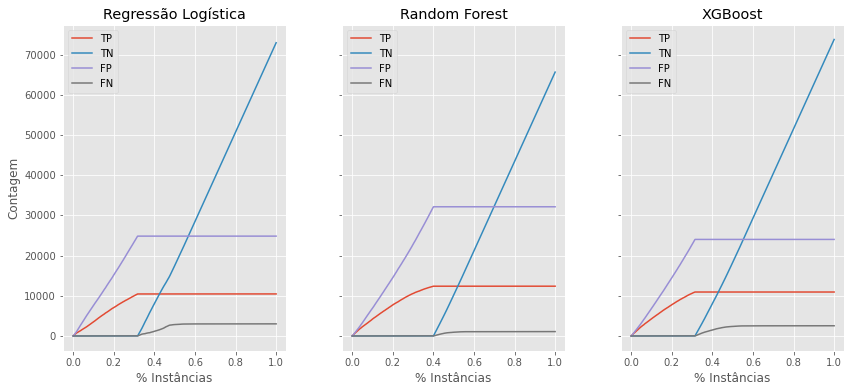

In [389]:
fig, axes = plt.subplots(1,3,figsize=(14,6), sharey=True)
metrics = ['tp','tn','fp','fn']
titles = ['TP','TN','FP','FN']
# LR
for metric,title in zip(metrics,titles):
    axes[0].plot(lr_cost['Instances'], lr_cost[metric], label=title)
    axes[1].plot(rfc_cost['Instances'], rfc_cost[metric], label=title)
    axes[2].plot(xgb_cost['Instances'], xgb_cost[metric], label=title)
    
axes[0].legend(loc='upper left')
axes[0].set(title='Regressão Logística', xlabel='% Instâncias', ylabel='Contagem')
# RFC
axes[1].legend(loc='upper left')
axes[1].set(title='Random Forest',xlabel='% Instâncias')
# XGB
axes[2].legend(loc='upper left')
axes[2].set(title='XGBoost', xlabel='% Instâncias')

plt.subplots_adjust(wspace=0.25)
plt.show()

### 3.2.2. Constrained Budget
___
Considerando o caso em que se possui uma restrição orçamentária para a campanha de retenção, como, por exemplo \\$150,000. Nesse caso, como casa oferta de retenção custa \\$42.8, temos que:

$$ n_{ofertas} = \frac{orçamento}{custo} = \frac{\\$150000}{\\$42.8} = \approx 3505$$

Nesse escopo, teríamos que a porcentagem de instâncias de teste seria $n_{ofertas}/n_{clientes} \to 3505/111237 \to $3.15%, o classificador XGBoost apresenta o maio lucro esperado, como visto abaixo e comentado acima.

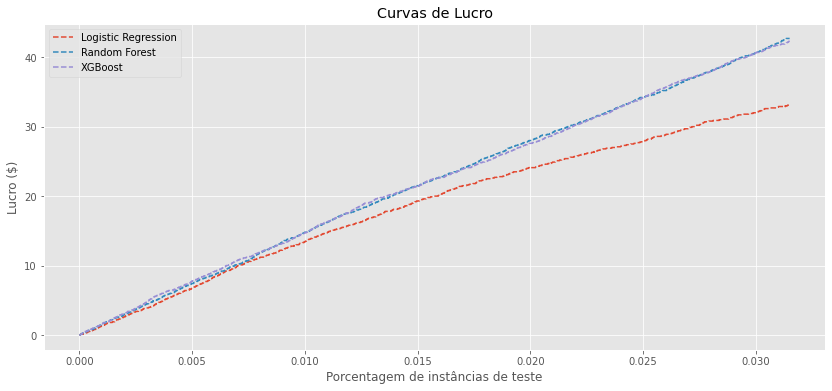

In [390]:
fig, ax=plt.subplots(figsize=(14,6))
ax.plot(lr_cost['Instances'][:3505],lr_cost['EV'][:3505], linestyle='--', label='Logistic Regression')
ax.plot(rfc_cost['Instances'][:3505],rfc_cost['EV'][:3505], linestyle='--', label='Random Forest')
ax.plot(xgb_cost['Instances'][:3505],xgb_cost['EV'][:3505], linestyle='--', label='XGBoost')
plt.legend()
ax.set(title='Curvas de Lucro', xlabel='Porcentagem de instâncias de teste',
      ylabel='Lucro ($)');

### 3.2.3. ROI
___

O retorno sobre investimento pode ser calculado como:

$$ROI = \frac{retorno}{investimento} \to \frac{retenção}{marketing}$$

Considerando, portanto, o cenário com restrição de orçamento, onde o marketing foi aplicado a 3.15% dos clientes i.e. 3505 clientes, temos um custo de, claramente, \\$150000 e, de acordo com o gráfico, utilizando o modelo XGBoost, temos um (máximo) lucro esperado de \\$42.3. Nesse caso:

$$ROI = \frac{42.3}{150000} \to 0.03\%$$

Ou seja, o ROI da campanha de marketing é extremamente baixo, de apenas 0.03%.

In [391]:
print('XGBoost: Lucro esperado para 3.15% dos clientes: ${}'.format(
    round(xgb_cost.iloc[3505,:]['EV'],2))
)

XGBoost: Lucro esperado para 3.15% dos clientes: $42.3


### 3.2.4. Perda de Receita
___
Calculando rapidamente a perda de receita, desconsiderando os modelos e apenas os dados reais de teste, teríamos que a perda de receita para empresa seria a multiplicação entre número $n$ de clientes que não apresentaram interesse no seguro i.e. Response=0, e o LTV do cliente, ou seja, o prêmio, considerado o valor médio utilizado na matriz de custo-benefício, de \\$1483.2.

In [392]:
print('Perda de receita: ${}'.format(
    round(np.unique(y_test, return_counts=True)[1][0] * 1483.2,2))
     )

Perda de receita: $145003564.8


# 4. Sumarização
____

Entre as métricas:

- ROC-AUC: XGBoost
- Valor Esperado: Random Forest
- Curvas de Lucro: Random Forest

Portanto, nota-se que o melhor modelo em função do problema de negócio seria o modelo Random Forest, o qual se mostrou melhor em 2 das 3 métricas utilizadas na análise, e será, portanto, o modelo a ser utilizado na próxima fase do projeto: previsão de um novo dataset.

# 5. Salvar modelo
___

Salvar o modelo para posterior utilização em novos dados

In [396]:
import pickle

In [397]:
pickle.dump(rfc, open('rfc','wb'))